<a href="https://colab.research.google.com/github/chaumintruong/AIO_Project/blob/module01_LLM_PDFQA/LLM_PDFQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**RAG Program**

**RAG (Retrieval Augmented Generation)** là kỹ thuật giúp LLMs cải thiện chất lượng kết quả tạo sinh bằng cách tích hợp nội dung truy vấn từ nguồn tài liệu nào đó để trả lời cho câu hỏi đầu vào.



*   **Input**: File tài liệu cần hỏi đạp và một câu hỏi liên quan đến nội dung tài liệu.
*   **Output**: Câu trả lời


Tổng quan về luồng xử lý (pipline) của chương trình RAG được thực hiện như sau:

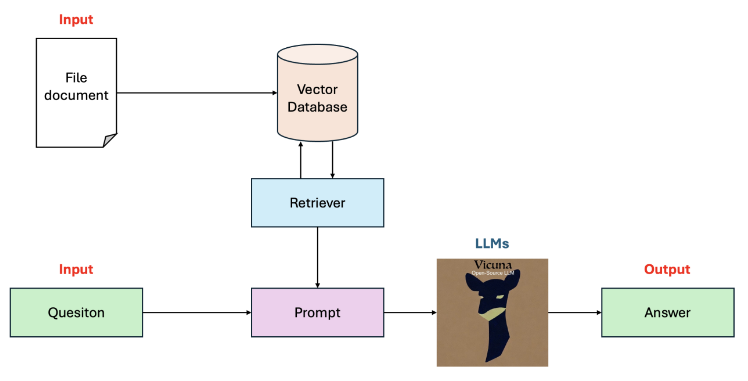



##**1. Install Required Libraries**

In [1]:
!pip install -q transformers==4.41.2
!pip install -q bitsandbytes==0.43.1
!pip install -q accelerate==0.31.0
!pip install -q langchain==0.2.5
!pip install -q langchainhub==0.1.20
!pip install -q langchain-chroma==0.1.1
!pip install -q langchain-community==0.2.5
!pip install -q langchain_huggingface==0.0.3
!pip install -q python-dotenv==1.0.1
!pip install -q pypdf==4.2.0
!pip install -q numpy==1.24.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.8/332.8 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

##**2. Build Vector Database**

Để thực hiện truy vấn, chúng ta phải có một cơ sở dữ liệu. Với dữ liệu nguồn là file pdf, chúng ta sẽ xử lý nội dung file pdf thành cơ sở dữ liệu dựa trên các bước sau:


1.   Load file
2.   Text Splitter
3.   Vectorization
4.   Vector Database



###**1. Import Required Libraries**

In [2]:
import torch
from transformers import BitsAndBytesConfig, AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_huggingface.llms import HuggingFacePipeline
from langchain.memory import ConversationBufferMemory
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from langchain.chains import ConversationalRetrievalChain
from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain import hub

###**2. Read File PDF**

In [3]:
Loader = PyPDFLoader
FILE_PATH = "./YOLOv10_Tutorials.pdf"  # Replace with your PDF file path
loader = Loader(FILE_PATH)
documents = loader.load()

###**3. Create Text Splitter**

Hầu hết các trường hợp, vùng thông
tin mà chúng ta cần chỉ là một câu nào đó trong file văn bản lớn. Vì vậy, sẽ tốt hơn
nếu chúng ta tách file văn bản ra thành các đoạn văn bản nhỏ, và mỗi văn bản nhỏ
này ta sẽ coi như là một tài liệu trong cơ sở dữ liệu. Dựa vào ý tưởng trên, ta sẽ sử dụng class Text Splitter để thực hiện tác vụ trên.

In [4]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

In [5]:
docs = text_splitter.split_documents(documents)
print("Number of sub - documents: ", len(docs))
print(docs[0])

Number of sub - documents:  33
page_content='AI VIET NAM – AI COURSE 2024\nTutorial: Phát hiện đối tượng trong ảnh với\nYOLOv10\nDinh-Thang Duong, Nguyen-Thuan Duong, Minh-Duc Bui và\nQuang-Vinh Dinh\nNgày 20 tháng 6 năm 2024\nI. Giới thiệu\nObject Detection (Tạm dịch: Phát hiện đối tượng) là một bài toán cổ điển thuộc lĩnh vực\nComputer Vision. Mục tiêu của bài toán này là tự động xác định vị trí của các đối tượng trong\nmột tấm ảnh. Tính tới thời điểm hiện tại, đã có rất nhiều phương pháp được phát triển nhằm\ngiải quyết hiệu quả bài toán này. Trong đó, các phương pháp thuộc họ YOLO (You Only Look\nOnce) thu hút được sự chú ý rất lớn từ cộng đồng nghiên cứu bởi độ chính xác và tốc độ thực\nthi mà loại mô hình này mang lại.\nHình 1: Logo của mô hình YOLO. Ảnh: link.\nThời gian vừa qua, Ao Wang và các cộng sự tại Đại học Thanh Hoa (Tsinghua University)\nđã đề xuất mô hình YOLOv10 trong bài báo YOLOv10: Real-Time End-to-End Object\nDetection [10]. Với những cải tiến mới, mô hình đã đạt 

###**4. Create Instance Vectorization**

Các văn bản gốc được biểu diễn dưới dạng string.
Nếu giữ dạng biểu diễn này, việc truy vấn sẽ gặp khó khăn và kết quả truy vấn không
được chính xác. Để khắc phục việc này, chúng ta có thể thực hiện chuyển đổi các văn
bản thành các vector.

In [6]:
embedding = HuggingFaceEmbeddings()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

###**5. Create Vector Database**

In [7]:
vector_db = Chroma.from_documents(documents=docs, embedding=embedding)
retriever = vector_db.as_retriever()

In [8]:
result = retriever.invoke (" What is YOLO ?")

print(" Number of relevant documents : ", len(result))

 Number of relevant documents :  4


##**3. Create LLM**

In [9]:
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [10]:
MODEL_NAME = "lmsys/vicuna-7b-v1.5"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=nf4_config,
    device_map="auto",
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/162 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

In [11]:
model_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    pad_token_id=tokenizer.eos_token_id,
    device_map="auto"
)

llm = HuggingFacePipeline(pipeline=model_pipeline)

##**4. Run Model**

In [12]:
prompt = hub.pull("rlm/rag-prompt")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

USER_QUESTION = "What is YOLO ?"
output = rag_chain.invoke(USER_QUESTION)
answer = output.split("Answer: ")[1].strip()
print(answer)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


YOLO (You Only Look Once) is a real-time object detection system that uses a single neural network to simultaneously detect objects in an image and determine their locations and categories. It was developed by Ultralytics, a team of researchers from Vietnam.


#**Build Interface Chatbot with Chainlit**

##**1. Install Packages**

In [15]:
!pip install -q transformers==4.41.2
!pip install -q bitsandbytes==0.43.1
!pip install -q accelerate==0.31.0
!pip install -q langchain==0.2.5
!pip install -q langchainhub==0.1.20
!pip install -q langchain-chroma==0.1.1
!pip install -q langchain-community==0.2.5
!pip install -q langchain-openai==0.1.9
!pip install -q langchain_huggingface==0.0.3
!pip install -q chainlit==1.1.304
!pip install -q python-dotenv==1.0.1
!pip install -q pypdf==4.2.0
!npm install -g localtunnel
!pip install -q numpy==1.24.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.5/327.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

##**2. Import Required Libraries**

In [16]:
import chainlit as cl
import torch

from chainlit.types import AskFileResponse

from transformers import BitsAndBytesConfig, AutoTokenizer, AutoModelForCausalLM, pipeline

from langchain_huggingface.llms import HuggingFacePipeline
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.memory import ConversationBufferMemory
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from langchain.chains import ConversationalRetrievalChain
from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain import hub


##**3. Reinstall Functions and Instances in RAG**

In [17]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

embedding = HuggingFaceEmbeddings ()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


##**4. Build Function for Input**

In [18]:
def process_file(file: AskFileResponse):
  if file.type == "text/plain":
    Loader = TextLoader
  elif file.type == "application/pdf":
    Loader = PyPDFLoader

  loader = Loader(file.path)
  documents = loader.load()
  docs = text_splitter.split_documents(documents)
  for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"
  return docs

##**5. Build the Chroma Database Initialization Function**

In [19]:
def get_vector_db(file: AskFileResponse):
  docs = process_file(file)
  cl.user_session.set("docs", docs)
  vector_db = Chroma.from_documents(documents=docs, embedding=embedding)
  return vector_db

##**6. Create LLM**

In [20]:
def get_huggingface_llm(model_name: str = "lmsys/vicuna-7b-v1.5",
                        max_new_tokens: int = 512):
  nf4_config = BitsAndBytesConfig(
      load_in_4bit=True,
      bnb_4bit_use_double_quant=True,
      bnb_4bit_quant_type="nf4",
      bnb_4bit_compute_dtype=torch.bfloat16
  )
  model = AutoModelForCausalLM.from_pretrained(
      model_name,
      quantization_config=nf4_config,
      low_cpu_mem_usage=True,
      device_map="auto",
      trust_remote_code=True
  )
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  model_pipeline = pipeline(
      "text-generation",
      model=model,
      tokenizer=tokenizer,
      max_new_tokens=max_new_tokens,
      pad_token_id=tokenizer.eos_token_id,
      device_map="auto"
  )
  llm = HuggingFacePipeline(pipeline=model_pipeline)
  return llm

LLM = get_huggingface_llm()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

##**7. Create Welcome Message**

In [21]:
welcome_message = """Welcome to the PDF QA! to get started:
1. Upload a PDF or text file
2. Ask a question about the file
"""

##**8. Create `on_chat_start` Function**

In [23]:
@cl.on_chat_start
async def on_chat_start():
  files = None
  while files in None:
    files = await cl.AskFileMessage(
        content=welcome_message,
        accept=["text/plain", "application/pdf"],
        max_size_mb=20,
        timeout=180,
    ).send()
  file = files[0]

  msg = cl.Message(content=f"Processing '{file.name}'...")
  await msg.send()

  vector_db = await cl.make_async(get_vector_db)(file)

  message_history = ChatMessageHistory()
  memory = ConversationBufferMemory(
      memory_key="chat_history",
      output_key="answer",
      chat_memory=message_history,
      return_messages=True
  )
  retriever = vector_db.as_retriever(search_type="mmr",
                                     search_kwargs={'k': 3})

  chain = ConversationalRetrievalChain.from_llm(
      llm=LLM,
      chain_type="stuff",
      retriever=retriever,
      memory=memory,
      return_source_documents=True
  )

  msg.content = f"'{file.name}' processed. You can now ask questions!"
  await msq.update()

  cl.user_session.set("chain", chain)

##**9. Create `on_message` Function**

In [24]:
@cl.on_message
async def on_message(message: cl.Message):
  chain = cl.user_session.get("chain")
  cb = cl.AsyncLangChainCallbackHandler()
  res = await chain.ainvoke(message.content, callbacks=[cb])
  answer = res["answer"]
  source_documents = res["source_documents"]
  text_elements = []

  if source_documents:
    for source_idx, source_doc in enumerate(source_documents):
      source_name = f"source_{source_idx}"
      text_elements.append(
          cl.Text(content=source_doc.page_content, name=source_name)
      )
    source_names = [text_el.name for text_el in text_elements]

    if source_names:
      answer += f"\nSources: {', '.join(source_names)}"
    else:
      answer += "\nNo sources found"

  await cl.Message(content=answer, elements=text_elements).send()


##**10. Run Chainlit app**

In [25]:
!chainlit run app.py --host 0.0.0.0 --port 8000 & >/ content / logs . txt &

/bin/bash: line 1: /: Is a directory
Usage: chainlit run [OPTIONS] TARGET
Try 'chainlit run --help' for help.

Error: Invalid value: File does not exist: app.py


##**11. Expose localhost to public host using localtunnel:**

In [28]:
import urllib

print("Password/Enpoint IP for localtunnel is:", urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 34.143.223.28


In [29]:
!lt --port 8000 -- subdomain aivn - simple - rag

your url is: https://loose-baboons-vanish.loca.lt
/tools/node/lib/node_modules/localtunnel/bin/lt.js:81
    throw err;
    ^

Error: connection refused: localtunnel.me:40617 (check your firewall settings)
    at Socket.<anonymous> (/tools/node/lib/node_modules/localtunnel/lib/TunnelCluster.js:52:11)
    at Socket.emit (events.js:315:20)
    at emitErrorNT (internal/streams/destroy.js:106:8)
    at emitErrorCloseNT (internal/streams/destroy.js:74:3)
    at processTicksAndRejections (internal/process/task_queues.js:80:21)
